In [41]:
import time
import numpy as np
import pyscf

def restricted_HF_convE_and_DM(mol, conv_tol = 1e-10):
    """Restricted Hartree-Fock method, following Szabo and Ostlund.
    """
    start = time.time()

    n_a = mol.nelec[0]

    T = mol.intor("int1e_kin")
    Vnuc = mol.intor("int1e_nuc")
    hcore = T + Vnuc
    S = mol.intor("int1e_ovlp")
    h2e = mol.intor('int2e', aosym="s1") # most expensive, least intelligent way of doing this.

    convE = 10
    convDM = 10
    convComm = 10

    # we now implement checking convergence of both density matrix as well as energy.

    s, U = np.linalg.eigh(S)
    
    s_inv_sqrt = np.diag([x**(-0.5) for x in s])

    X = U @ s_inv_sqrt @ U.conj().T

    F0 = X.T @ hcore @ X
    _, C0 = np.linalg.eigh(F0)
    C = X @ C0
    P = 2 * C[:, :n_a] @ C[:, :n_a].T

    Eprev = None

    while convE > conv_tol or convDM > conv_tol or convComm > conv_tol:
        
        G = np.einsum('ij,klji->kl',P,h2e) - 0.5 * np.einsum('ij,kijl->kl',P,h2e)
        F = hcore + G

        E0 = 0.5 * np.einsum('ij,ij->',P,hcore+F)

        if Eprev is not None:
            convE = np.abs(E0 - Eprev)

        convComm = np.linalg.norm(F @ P @ S - S @ P @ F, 'fro')

        if convE < conv_tol and convDM < conv_tol and convComm < conv_tol:
            break
        
        Eprev = E0

        Fp = X.conj().T @ F @ X
        eps, Cp = np.linalg.eigh(Fp)
        C = X @ Cp

        Pnew = 2 * C[:,0:n_a] @ C[:,0:n_a].conj().T
        convDM = np.linalg.norm(Pnew-P)
        P = Pnew


        # if convE < conv_tol and convDM < conv_tol and convComm < conv_tol:

        #     Eprev = E0

        #     Fp = X.conj().T @ F @ X
        #     eps, Cp = np.linalg.eigh(Fp)
        #     C = X @ Cp

        #     Pnew = 2 * C[:,0:n_a] @ C[:,0:n_a].conj().T
        #     convDM = np.linalg.norm(Pnew-P)
        #     P = Pnew

        #     break
        
        # Eprev = E0

        # Fp = X.conj().T @ F @ X
        # eps, Cp = np.linalg.eigh(Fp)
        # C = X @ Cp

        # Pnew = 2 * C[:,0:n_a] @ C[:,0:n_a].conj().T
        # convDM = np.linalg.norm(Pnew-P)
        # P = Pnew

    E0 = E0 + mol.energy_nuc()

    end = time.time()
    print(f"Converged in {end - start} seconds")

    return E0, P, F, C


In [ ]:
import itertools
import numpy as np
import scipy as sp

def ccsd(mol, reference, norb, nelec):

    T = mol.intor("int1e_kin")
    Vnuc = mol.intor("int1e_nuc")
    hcore = T + Vnuc

    # assume restricted HF reference

    nalpha = nelec//2
    nbeta = nelec-nalpha
    nocc = nalpha

    E0 = reference[0]
    Pref = reference[1]
    Fock = reference[2]
    C = reference[3]

    # now need to get MOs

    orbital_energies = np.diag(C.T @ Fock @ C)

    occupied = C[:, :nalpha]
    unoccupied = C[:, nalpha:]

    # we would like to transform into the MO basis.

    F_mo = C.T @ Fock @ C

    # hcore_mo = C.T @ hcore @ C
    hcore_mo = np.einsum('ab,ai,bj->ij',hcore,C,C)

    h2e = mol.intor('int2e', aosym="s1")

    h2e_mo = np.einsum('pqrs, pi, qj, rk, sl -> ijkl', h2e, C, C, C, C, optimize = True)
    gpqrs = h2e_mo

    Lpqrs = np.zeros_like(gpqrs)
    for p in range(norb):
        for q in range(norb):
            for r in range(norb):
                for s in range(norb):
                    Lpqrs[p,q,r,s] = 2*gpqrs[p,q,r,s] - gpqrs[p,s,r,q]

    t1ai = np.zeros((norb, norb))
    t2ijab = np.zeros((norb,norb,norb,norb))

    # initial guess for t1 amplitudes should be zero
    # initial guess for t2 amplitudes should be the MP2 result, which happens to be:
    # (2(ia|jb) - (ib|ja))/(Dijab)

    for i in range(nalpha):
        for j in range(nalpha):
            for a in range(nalpha,norb):
                for b in range(nalpha,norb):
                    Dijab = orbital_energies[a] + orbital_energies[b] - orbital_energies[i] - orbital_energies[j]
                    t2ijab[i, j, a, b] = Lpqrs[i,a,j,b] / Dijab

    uijab = np.zeros_like(t2ijab)
    for i in range(nalpha):
        for j in range(nalpha):
            for a in range(nalpha,norb):
                for b in range(nalpha,norb):
                    uijab[i,j,a,b] = 2*t2ijab[i,j,a,b] - t2ijab[j,i,a,b]

    en_CCSD = np.einsum('ijab,iajb->',t2ijab,Lpqrs) + np.einsum('ai,bj,iajb->',t1ai,t1ai,Lpqrs)
    print(en_CCSD)

    def generateX(t):
        return np.eye(norb,norb) - t

    def generateY(t):
        return np.eye(norb,norb) + t.T                    

    
    # need inactive Fock matrix; (10.8.28): Fmn = hmn + sum_i (2g_mnii - g_miin)

    
    converged = False

    while not converged:
        xmatrix = generateX(t1ai)
        ymatrix = generateY(t1ai)

        hcore_mo_t1 = np.einsum('pr,qs,rs->pq',xmatrix, ymatrix, hcore_mo)
        gpqrs_mo_t1 = np.einsum('pt,qu,rm,sn,tumn->pqrs', xmatrix, ymatrix,
                                   xmatrix, ymatrix, h2e_mo)

        # occ = slice(None, nalpha)

        F_inactive_t1 = hcore_mo_t1 + 2*np.einsum('mnii->mn', gpqrs_mo_t1[:,:,:nocc,:nocc]) - np.einsum('miin->mn',gpqrs_mo_t1[:,:nocc,:nocc,:])
        Lpqrs_t1 = np.zeros_like(gpqrs_mo_t1)
        for p in range(norb):
            for q in range(norb):
                for r in range(norb):
                    for s in range(norb):
                        Lpqrs_t1[p,q,r,s] = 2*gpqrs_mo_t1[p,q,r,s] - gpqrs_mo_t1[p,s,r,q]
        
        omegaA1_ai = np.einsum('kicd,adkc->ai',uijab, gpqrs_mo_t1) # seems correct; 13.7.80
        omegaB1_ai = -np.einsum('klac, kilc->ai',uijab, gpqrs_mo_t1) # seems correct; 13.7.81
        omegaC1_ai = np.einsum('ikac,kc->ai',uijab, F_inactive_t1) # 13.7.82
        omegaD1_ai = F_inactive_t1 # 13.7.83

        omegaA2_aibj = gpqrs_mo_t1 + np.einsum('ijcd,acbd->aibj',t2ijab, gpqrs_mo_t1) # 13.7.101
        
        omegaB2_aibj = np.einsum('klab,kilj->aibj',t2ijab, gpqrs_mo_t1 + np.einsum('ijcd,kcld->kilj',t2ijab,gpqrs_mo_t1)) # 13.7.102
        
        omegaC2_aibj = -0.5*np.einsum('kjbc,kiac->aibj',t2ijab,gpqrs_mo_t1 - 
                                      0.5*np.einsum('liad,kdlc->kiac',t2ijab,gpqrs_mo_t1)) -np.einsum('kibc,kjac->aibj',t2ijab,gpqrs_mo_t1 - 0.5*np.einsum('ljad,kdlc->kjac',t2ijab,gpqrs_mo_t1)) #13.7.103
        
        omegaD2_aibj = 0.5*np.einsum('jkbc,aikc->aibj',uijab,Lpqrs_t1 + 0.5*np.einsum('ilad,ldkc->aikc',uijab,Lpqrs_t1))
        
        omegaE2_aibj = np.einsum('ijac,bc->aibj',t2ijab,F_inactive_t1 - 
                                 np.einsum('klbd,ldkc->bc',uijab,gpqrs_mo_t1)) - np.einsum('ikab,kj->aibj',t2ijab,F_inactive_t1+np.einsum('ljcd,kdlc->kj',uijab,gpqrs_mo_t1)) 
        
        # the above equations - i think the einsumming is done correctly, so I don't know what's wrong...


        # omegaC2_bjai = -0.5*np.einsum('kiac,kjbc->aibj',t2ijab,gpqrs_mo_t1 - 
        #                               0.5*np.einsum('ljbd,kdlc->kjbc',t2ijab,gpqrs_mo_t1))-np.einsum('kjac,kibc->aibj',t2ijab,gpqrs_mo_t1-0.5*np.einsum('libd,kdlc->kibc',t2ijab,gpqrs_mo_t1))

        # omegaD2_bjai = 0.5*np.einsum('ikac,bjkc->aibj',uijab,Lpqrs_t1 + 0.5 * np.einsum('jlbd,ldkc->bjkc',uijab,Lpqrs_t1))

        # omegaE2_bjai = np.einsum('jibc,ac->aibj',t2ijab,F_inactive_t1 - 
        #                          np.einsum('klad,ldkc->ac',uijab,gpqrs_mo_t1)) - np.einsum('jkba,ki->aibj',t2ijab,F_inactive_t1 - np.einsum('licd,kdlc->ki',uijab,gpqrs_mo_t1))


        # omegaC2_bjai = -0.5*np.einsum('kiac,kjbc->bjai',t2ijab,gpqrs_mo_t1 - 
        #                               0.5*np.einsum('ljbd,kdlc->kjbc',t2ijab,gpqrs_mo_t1))-np.einsum('kjac,kibc->bjai',t2ijab,gpqrs_mo_t1-0.5*np.einsum('libd,kdlc->kibc',t2ijab,gpqrs_mo_t1))

        # omegaD2_bjai = 0.5*np.einsum('ikac,bjkc->bjai',uijab,Lpqrs_t1 + 0.5 * np.einsum('jlbd,ldkc->bjkc',uijab,Lpqrs_t1))

        # omegaE2_bjai = np.einsum('jibc,ac->bjai',t2ijab,F_inactive_t1 - 
        #                          np.einsum('klad,ldkc->ac',uijab,gpqrs_mo_t1)) - np.einsum('jkba,ki->bjai',t2ijab,F_inactive_t1 - np.einsum('licd,kdlc->ki',uijab,gpqrs_mo_t1))



        omega1_ai = omegaA1_ai + omegaB1_ai + omegaC1_ai + omegaD1_ai
        # print(omega1_ai[:,2])

        omega2_aibj = omegaA2_aibj + omegaB2_aibj + omegaC2_aibj + omegaD2_aibj + omegaE2_aibj + np.einsum('ijab->jiba', omegaC2_aibj + omegaD2_aibj + omegaE2_aibj)

        # omega2_aibj = omegaA2_aibj + omegaB2_aibj + omegaC2_aibj + omegaD2_aibj + omegaE2_aibj + omegaC2_bjai + omegaD2_bjai + omegaE2_bjai

        # now update t2 amplitudes

        for i in range(nalpha):
            for j in range(nalpha):
                for a in range(nalpha,norb):
                    for b in range(nalpha,norb):
                        if i != j or a != b:
                            t2ijab[i,j,a,b] = t2ijab[i,j,a,b] - omega2_aibj[a,i,b,j]/(orbital_energies[a]+orbital_energies[b]-orbital_energies[i]-orbital_energies[j])
                        elif i == j and a == b:
                            t2ijab[i,j,a,b] = t2ijab[i,j,a,b] - omega2_aibj[a,i,b,j]/(orbital_energies[a]+orbital_energies[b]-orbital_energies[i]-orbital_energies[j])


        
        for i in range(nalpha):
            for a in range(nalpha,norb):
                t1ai[a,i] = t1ai[a,i] - omega1_ai[a,i]/(orbital_energies[a] - orbital_energies[i])


        # en_CCSD_new = np.einsum('ijab,iajb->',t2ijab,Lpqrs) + np.einsum('ai,bj,iajb->',t1ai,t1ai,Lpqrs)
        en_CCSD_new = np.einsum('ijab,iajb->',t2ijab[:nocc,:nocc,nocc:norb,nocc:norb],Lpqrs[:nocc,nocc:norb,:nocc,nocc:norb]) + np.einsum('ai,bj,iajb->',t1ai[nocc:norb,:nocc],t1ai[nocc:norb,:nocc],Lpqrs[:nocc,nocc:norb,:nocc,nocc:norb])

        if en_CCSD is not None:
            if np.abs(en_CCSD_new - en_CCSD) < 1e-10:
                en_CCSD = en_CCSD_new
                converged = True
        
        en_CCSD = en_CCSD_new
        print(en_CCSD)
    
    return en_CCSD, t1ai, t2ijab, omega1_ai, omega2_aibj

In [43]:
## pyscf calculation

from pyscf import gto, scf, cc
from pyscf.cc.ccd import CCD

import numpy as np
import scipy as sp

mol = gto.Mole()
mol.atom = """
H    0.0    0.0    0.0
O    1.0    0.0    0.0
H    2.0    0.0    0.0
"""
mol.basis = 'sto-3g'
mol.charge = 0
mol.spin = 0
mol.build()

print("orbitals:",mol.nao)
print("elec:",mol.nelec)

soln = restricted_HF_convE_and_DM(mol)

mf = scf.RHF(mol)
start = time.time()
mf.kernel()
end = time.time()

print(start - end, "seconds for RHF")


start = time.time()
mycc = cc.CCSD(mf)
mycc.kernel()
end = time.time()
print(start - end, "seconds for CCSD")

orbitals: 7
elec: (5, 5)
Converged in 0.22463560104370117 seconds
converged SCF energy = -74.8415921601714
-0.7473218441009521 seconds for RHF
E(CCSD) = -74.88203711153517  E_corr = -0.04044495136374243
-0.34778475761413574 seconds for CCSD


In [44]:
ccsd(mol,soln,7,10)

0.036734163639674314
-0.015995286355604918
-0.029968137570146852
-0.035204023089297626
-0.037176206507386116
-0.037934640183666685
-0.03823491019615796
-0.038359319136746554
-0.03841500549145997
-0.038443079788748086
-0.03845953965616919
-0.03847072179089397
-0.0384792063135216
-0.038486093126259655
-0.03849188849488069
-0.03849685401810419
-0.03850114575819273
-0.03850487068021673
-0.038508110169369614
-0.03851093027859563
-0.038513386537111866
-0.03851552647053317
-0.03851739111524444
-0.03851901605765731
-0.03852043222348961
-0.038521666516722945
-0.038522742355555854
-0.038523680130302766
-0.038524497598230484
-0.03852521022557797
-0.03852583148450051
-0.03852637311117737
-0.0385268453302994
-0.038527257050382985
-0.03852761603373803
-0.03852792904440094
-0.038528201976904715
-0.03852843996837943
-0.03852864749615014
-0.03852882846271582
-0.03852898626974715
-0.038529123882527584
-0.038529243886076224
-0.03852934853403049
-0.03852943979122555
-0.03852951937078654
-0.038529588766442

(-0.038530059615497235,
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-6.43123002e-05,  6.79436550e-03, -2.21148518e-15,
          1.24827784e-16,  7.27005890e-17,  0.00000000e+00,
          0.00000000e+00],
        [-2.21288553e-17,  7.26431216e-16,  6.69030416e-03,
         -3.45174136e-17, -3.81891

In [16]:
mf.MP2().run()

E(MP2) = -74.8709226561204  E_corr = -0.0293304959489362
E(SCS-MP2) = -74.8746499179775  E_corr = -0.0330577578060394


In [10]:
print(mol.nelec)

(5, 5)


In [25]:
mycc.t1

array([[-3.66562670e-05,  1.63055839e-16],
       [-9.87296029e-03,  5.16136785e-18],
       [ 2.09753485e-15, -5.99721796e-03],
       [-7.83792355e-18,  2.91869443e-17],
       [-5.56704268e-34, -3.39131107e-34]])

In [21]:
t1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-6.43123002e-05,  6.79436550e-03, -2.31068449e-15,
         1.24827784e-16,  7.27005890e-17,  0.00000000e+00,
         0.00000000e+00],
       [-3.13352082e-17,  4.77858523e-16,  6.69030416e-03,
        -3.45174136e-17, -3.81891552e-18,  0.00000000e+00,
         0.0000000

In [17]:
en, t1, t2, omega1, omega2 = ccsd(mol, soln, 7,10)

0.036734163639674314
[-3.94973037e-15  1.22738264e-15 -5.87604617e-01 -3.39536666e-17
 -4.98206083e-17  1.63791458e-15 -8.46156578e-03]
-0.01599528635560492
[-3.95885595e-15  1.53345001e-15 -5.86128601e-01 -3.48641692e-17
 -5.01423220e-17  4.86961439e-16 -1.39189440e-03]
-0.02996813757014686
[-3.96183762e-15  1.62362039e-15 -5.85871828e-01 -3.51705700e-17
 -5.02188304e-17  1.52839478e-16 -2.23143717e-04]
-0.03520402308929768
[-3.96285822e-15  1.65155540e-15 -5.85826855e-01 -3.53004600e-17
 -5.02432097e-17  4.97681437e-17 -3.38877140e-05]
-0.03717620650738614
[-3.96321205e-15  1.66051574e-15 -5.85818876e-01 -3.53623761e-17
 -5.02531886e-17  1.66182145e-17 -4.56809640e-06]
-0.03793464018366673
[-3.96333540e-15  1.66346549e-15 -5.85817432e-01 -3.53933029e-17
 -5.02578767e-17  5.64377546e-18 -4.29976105e-07]
-0.03823491019615798
[-3.96337854e-15  1.66445542e-15 -5.85817163e-01 -3.54090093e-17
 -5.02602073e-17  1.93845011e-18  2.67483038e-08]
-0.038359319136746554
[-3.96339364e-15  1.664792

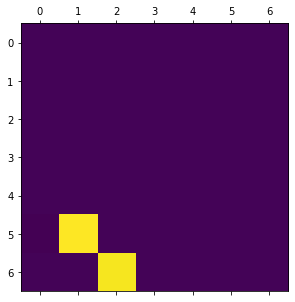

In [14]:
import matplotlib.pyplot as plt

plt.matshow(t1)

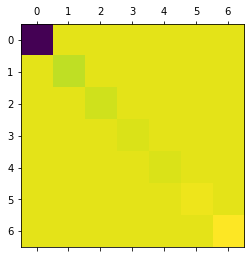

In [20]:
plt.matshow(omega1)

In [14]:
import itertools
import numpy as np
import scipy as sp

def ccsd_retry(mol, reference, norb, nelec):
    # maximal difference between reference and final function is in 2 spots

    T = mol.intor("int1e_kin")
    Vnuc = mol.intor("int1e_nuc")
    hcore = T + Vnuc

    # assume restricted HF reference

    nalpha = nelec//2
    nbeta = nelec-nalpha
    nocc = nalpha
    nvirt = norb - nalpha

    E0 = reference[0]
    Pref = reference[1]
    Fock = reference[2]
    C = reference[3]

    # now need to get MOs

    orbital_energies = np.diag(C.T @ Fock @ C)

    occupied = C[:, :nalpha]
    unoccupied = C[:, nalpha:]

    # we would like to transform into the MO basis.

    F_mo = C.T @ Fock @ C

    h1e_mo = C.T @ hcore @ C

    gpqrs = mol.intor('int2e', aosym="s1")
    gpqrs_mo = np.einsum('ijkl,ip,jq,kr,ls->pqrs',gpqrs,C,C,C,C)

    def generateX(t1):
        return np.eye(norb) - t1
    
    # make sure t1 is organized as a first index, i second index
    
    def generateY(t1):
        return np.eye(norb) + t1.T
    
    def denom(a,i,b,j):
        return orbital_energies[a] + orbital_energies[b] - orbital_energies[i] - orbital_energies[j]

    converged = False

    # need to guess t1 and t2 values

    t1ai = np.zeros((norb,norb))
    # we're gonna do this a bit differently.
    t2aibj = np.zeros((norb,norb,norb,norb))

    # guess the MP2 guess
    for a in range(nocc,norb):
        for b in range(nocc,norb):
            for i in range(nocc):
                for j in range(nocc):
                    
                    # initial guess (ai|bj)

                    t2aibj[a,i,b,j] = gpqrs_mo[a,i,b,j]/denom(a,i,b,j)

    Lpqrs_mo = 2*gpqrs_mo - np.einsum('pqrs->psrq',gpqrs_mo)


    while not converged:

        uaibj = 2*t2aibj - np.einsum('aibj->ajbi',t2aibj)

        xmatrix = generateX(t1ai)
        ymatrix = generateY(t1ai)


        h1e_mo_t1 = np.einsum('pr,qs,rs->pq',xmatrix,ymatrix,h1e_mo)
        gpqrs_mo_t1 = np.einsum('pt,qu,rm,sn,tumn->pqrs',xmatrix,ymatrix,xmatrix,ymatrix,gpqrs_mo)

        Lpqrs_mo_t1 = 2*gpqrs_mo_t1 - np.einsum('pqrs->psrq',gpqrs_mo_t1)

        # maybe assert the particle exchange symmetry being retained?

        # now, need inactive Fock (10.8.28)

        Fi_mo_t1 = h1e_mo_t1 + 2*np.einsum('mnii->mn',gpqrs_mo_t1[:,:,:nocc,:nocc]) - np.einsum('miin->mn',gpqrs_mo_t1[:,:nocc,:nocc,:])

        # now we start constructing our omega vectors

        omega_A1 = np.einsum('ckdi,adkc->ai',uaibj,gpqrs_mo_t1)
        omega_B1 = -np.einsum('akcl,kilc->ai',uaibj,gpqrs_mo_t1)
        omega_C1 = np.einsum('aick,kc->ai',uaibj,Fi_mo_t1)
        omega_D1 = Fi_mo_t1

        omega_A2 = gpqrs_mo_t1 + np.einsum("cidj,acbd->aibj",t2aibj,gpqrs_mo_t1)
        omega_B2 = np.einsum('akbl,kilj->aibj',t2aibj,gpqrs_mo_t1 + np.einsum('cidj,kcld->kilj',t2aibj,gpqrs_mo_t1))
        omega_C2 = -0.5*np.einsum('bkcj,kiac->aibj',t2aibj,gpqrs_mo_t1 -0.5*np.einsum('aldi,kdlc->kiac',t2aibj,gpqrs_mo_t1))
        - np.einsum('bkci,kjac->aibj',t2aibj,gpqrs_mo_t1 -0.5*np.einsum('aldj,kdlc->kjac',t2aibj,gpqrs_mo_t1))
        omega_D2 = 0.5*np.einsum('bjck,aikc->aibj',uaibj,Lpqrs_mo_t1+0.5*np.einsum('aidl,ldkc->aikc',uaibj,Lpqrs_mo_t1))
        omega_E2 = np.einsum('aicj,bc->aibj',t2aibj,Fi_mo_t1 - np.einsum('bkdl,ldkc->bc',uaibj,gpqrs_mo_t1))-np.einsum('aibk,kj->aibj',t2aibj,Fi_mo_t1+np.einsum('cldj,kdlc->kj',uaibj,gpqrs_mo_t1))

        omega1_ai = omega_A1 + omega_B1 + omega_C1 + omega_D1
        omega2_aibj = omega_A2 + omega_B2 + omega_C2 + omega_D2 + omega_E2 + np.einsum('aibj->bjai',omega_C2 + omega_D2 + omega_E2)

        for a in range(nocc,norb):
            for i in range(nocc):
                t1ai[a,i] = t1ai[a,i] - omega1_ai[a,i]/(orbital_energies[a]-orbital_energies[i])

        for a in range(nocc,norb):
            for b in range(nocc, norb):
                for i in range(nocc):
                    for j in range(nocc):
                        t2aibj[a,i,b,j] = t2aibj[a,i,b,j] - omega2_aibj[a,i,b,j]/denom(a,i,b,j)
        
        dEccsd = np.einsum('aibj,iajb->',t2aibj,Lpqrs_mo) + np.einsum('ai,bj,iajb->', t1ai,t1ai,Lpqrs_mo)

        print(dEccsd)

        if np.linalg.norm(omega1_ai[nocc:,:nocc]) < 1e-8 and np.linalg.norm(omega2_aibj[nocc:,:nocc,nocc:,:nocc]) < 1e-8:
            converged = True
        
    return dEccsd, t1ai, t2aibj


    

In [15]:
ccsd_retry(mol,soln,7,10)

-0.035953194701575736
-0.019823430407085535
-0.02523372723766207
-0.023229941185284535
-0.024061095034302298
-0.023704177091616343
-0.023862282445012328
-0.023791738758537982
-0.023823482035233625
-0.023809179879707137
-0.02381564132631945
-0.023812721740122125
-0.023814042272130326
-0.023813445020590043
-0.02381371525580116
-0.023813592990535686
-0.02381364831777823
-0.02381362328211734
-0.023813634611641453
-0.02381362948473913
-0.023813631804872008
-0.023813630754929135
-0.02381363123007282


(-0.02381363123007282,
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 2.76721295e-06, -5.97212215e-03, -1.88837593e-15,
          9.83705094e-17,  5.84490583e-17,  0.00000000e+00,
          0.00000000e+00],
        [-2.80838357e-17, -3.54444908e-18, -3.03867267e-03,
         -3.22492474e-17, -5.076515